In [1]:
import warnings
warnings.filterwarnings('ignore')

import scanpy as sc
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
import seaborn as sns
import copy
from matplotlib import gridspec
import matplotlib.patches as patches
import matplotlib
matplotlib.use('Agg')
from matplotlib import gridspec
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.font_manager as font_manager
import pandas as pd
font_dirs = ['/mnt/e/Misc/Python_Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
matplotlib.rcParams['font.family'] = 'tahoma'
import random
import scvelo as scv
from matplotlib.ticker import FormatStrFormatter

In [2]:
pkl_file = open('../data/d80_sbnx.pkl', 'rb')
adata = pkl.load(pkl_file)
adata.obs['line'] = ['zip13k5' for x in range(len(adata.obs))]
pkl_file.close()

genes = list(adata.var_names)
mito_genes = [gene for gene in genes if gene[:3] == 'MT-' or (gene[:2] == 'MT' and '.' in gene)]
rb_genes = [gene for gene in genes if gene[:3] in ['RNR','RPL','RPS','MRP'] or (gene[:2] == 'RP' and '.' in gene)]
adata.obs['n_counts'] = adata.X.sum(axis=1)
y=adata.X > 0
adata.obs['n_genes'] = y.sum(axis=1)
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.obs['percent_ribo'] = np.sum(adata[:, rb_genes].X, axis=1) / np.sum(adata.X, axis=1)
sub_cells = adata.obs[(adata.obs['n_counts'] < 10000) & (adata.obs['percent_mito'] < 0.4)]
adata = adata[sub_cells.index,:]
adata.obs['Index'] = range(len(adata.obs))

Trying to set attribute `.obs` of view, copying.


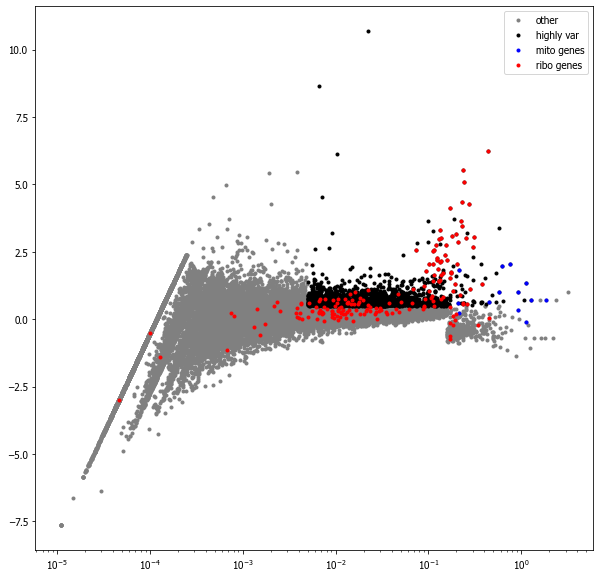

In [3]:
sc.pp.normalize_total(adata,)
adata.X = np.log1p(adata.X)


min_mean = 0.005
max_mean = 1.5

sc.pp.highly_variable_genes(adata)

top_ = sorted(adata.var['dispersions_norm'][(adata.var['means'] >= min_mean) & 
                                                      (adata.var['means'] < max_mean)],
                  reverse=True)[2000]
adata.var['highly_variable'] = (adata.var['dispersions_norm'] >= top_) \
& (adata.var['means'] >= min_mean) & (adata.var['means'] < max_mean)
adata.var[adata.var['highly_variable'] == True].sort_values(['means'],ascending=False)[0:50]
adata.var[adata.var['highly_variable'] == True].sort_values(['means'],ascending=True)[0:50]

plt.figure(figsize=(10,10))
plt.plot(adata.var[adata.var['highly_variable'] == False]['means'],adata.var[adata.var['highly_variable'] == False]['dispersions_norm'],'.',color='gray',label='other')
plt.plot(adata.var[adata.var['highly_variable'] == True]['means'],adata.var[adata.var['highly_variable'] == True]['dispersions_norm'],'.',color='black',label='highly var')
plt.plot(adata.var.loc[mito_genes]['means'],adata.var.loc[mito_genes]['dispersions_norm'],'.',color='blue',label='mito genes')
plt.plot(adata.var.loc[rb_genes]['means'],adata.var.loc[rb_genes]['dispersions_norm'],'.',color='red',label='ribo genes')
plt.xscale('log')
plt.legend()
plt.show()

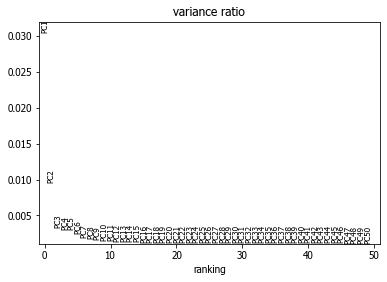

In [4]:
adata.raw_X = copy.deepcopy(adata.X)
adata.obs['line'] = adata.obs['line'].astype('category')

#z-score normalization
sc.pp.scale(adata,max_value=10)
adata.scaled_X = copy.deepcopy(adata.X)

#run PCA
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=False, n_pcs=50)

#set X back to log-scaled expression before z-score normalization
adata.X = adata.raw_X

In [5]:
sc.pp.neighbors(adata,n_neighbors=15)
sc.tl.umap(adata,min_dist=0.5)

In [6]:
sc.tl.louvain(adata,resolution=1)

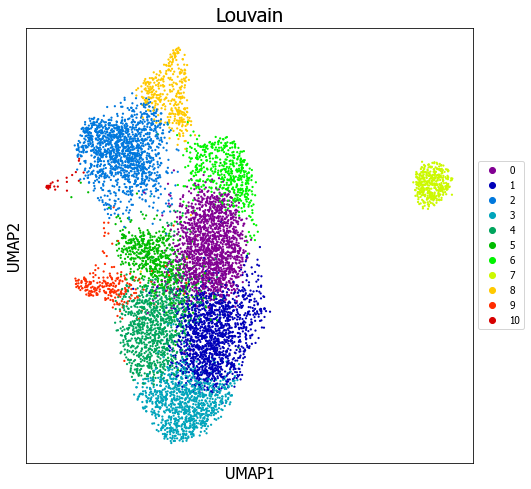

In [7]:
plt.figure(figsize=(10,8))
ax = plt.subplot(111)
clusts = sorted([int(x) for x in set(adata.obs['louvain'])])
clrs = sns.color_palette('nipy_spectral', n_colors=len(clusts))  # a list of RGB tuples
final_colors = []
for j,cell in enumerate(adata.obs['louvain']): 
    final_colors.append(clrs[int(cell)])

plt.scatter(adata.obsm['X_umap'][:,0],adata.obsm['X_umap'][:,1],c=final_colors,s=5,ec=None)
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
for j,cell_type in enumerate(clusts):
    plt.plot(-10000,-10000,'.',color=clrs[j],label=cell_type,markersize=12)

plt.title('Louvain', fontsize=20)
plt.xlabel('UMAP1',fontsize=16)
plt.ylabel('UMAP2',fontsize=16)
plt.xticks([])
plt.yticks([])

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=10)
plt.show()

CUX1
POU3F2
TLE3
BHLHE22
SATB2
CUX2
BCL11B
TBR1
SOX5
LMO3
FEZF2
SEMA3E


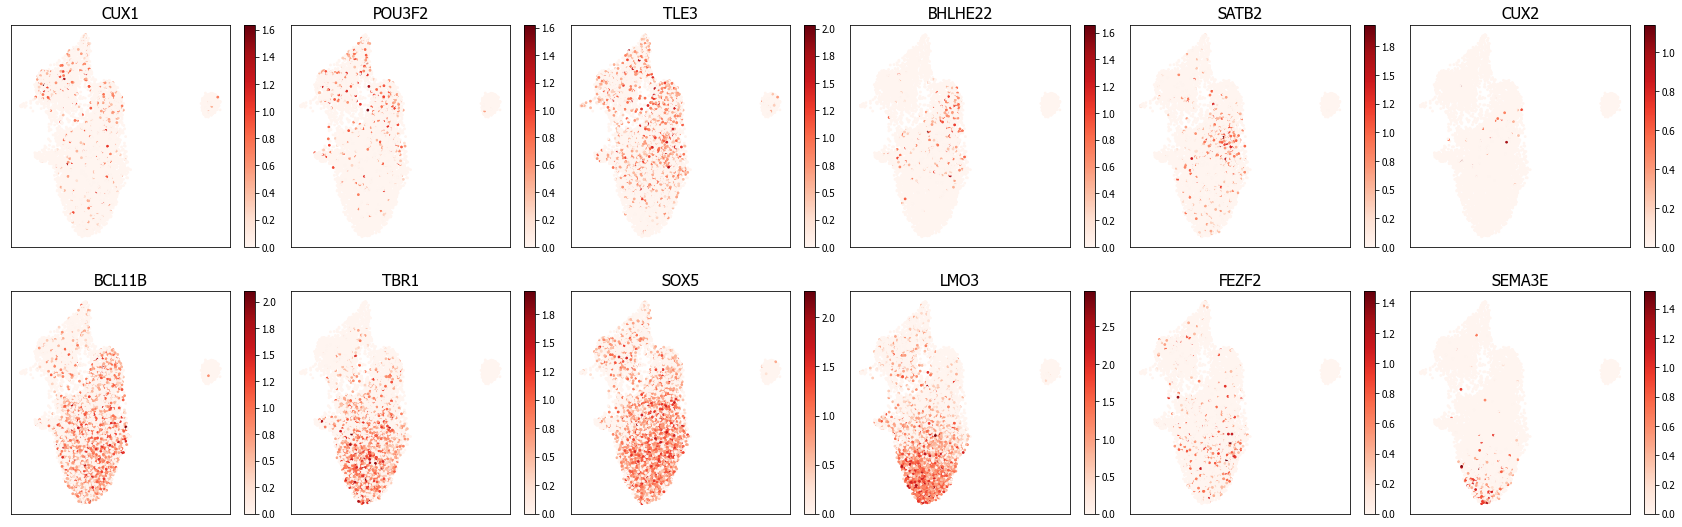

In [8]:
adata.var['index'] = range(len(adata.var))
plt.figure(figsize=(30,9))
for j,gene in enumerate(['CUX1','POU3F2','TLE3','BHLHE22','SATB2','CUX2',
                         'BCL11B','TBR1','SOX5','LMO3','FEZF2','SEMA3E']):    

    ax = plt.subplot(2,6,j+1)

    vmin = 0
    vmax = max(adata.X[:,adata.var.loc[gene]['index']])
    colormap = cm.Reds
    normalize = Normalize(vmin=vmin, vmax=vmax)
    xs = adata.obsm['X_umap'][:,0]
    ys = adata.obsm['X_umap'][:,1]
    plt.scatter(xs,ys,c=adata.X[:,list(adata.var.index).index(gene)],
                cmap=colormap,norm=normalize,s=3)

    print(gene)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.title(gene,fontsize=16)
    cbar = plt.colorbar()#colormap)
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
plt.subplots_adjust(hspace = .2,wspace = .02)

plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/Figures/Figure 6/upper_and_deep_layer_neurons.png',dpi=500,bbox_inches='tight')
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/Figures/Figure 6/upper_and_deep_layer_neurons.pdf',bbox_inches='tight')

CUX1
POU3F2
TLE3
BHLHE22
SATB2
CUX2


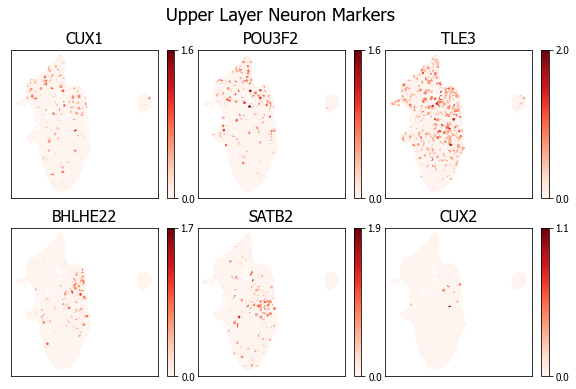

In [9]:
adata.var['index'] = range(len(adata.var))
plt.figure(figsize=(10,6))
for j,gene in enumerate(['CUX1','POU3F2','TLE3','BHLHE22','SATB2','CUX2']):    

    ax = plt.subplot(2,3,j+1)

    vmin = 0
    vmax = max(adata.X[:,adata.var.loc[gene]['index']])
    colormap = cm.Reds
    normalize = Normalize(vmin=vmin, vmax=vmax)
    xs = adata.obsm['X_umap'][:,0]
    ys = adata.obsm['X_umap'][:,1]
    plt.scatter(xs,ys,c=adata.X[:,list(adata.var.index).index(gene)],
                cmap=colormap,norm=normalize,s=3)

    print(gene)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.title(gene,fontsize=16)
    cbar = plt.colorbar()#colormap)
    cbar.set_ticks([0,vmax],[0,vmax])
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
plt.subplots_adjust(hspace = .2,wspace = .02)
plt.suptitle('Upper Layer Neuron Markers',fontsize=18)
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/Figures/Figure 6/upper_layer_neurons.png',dpi=500,bbox_inches='tight')
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/Figures/Figure 6/upper_layer_neurons.pdf',bbox_inches='tight')

BCL11B
TBR1
SOX5
LMO3
FEZF2
SEMA3E


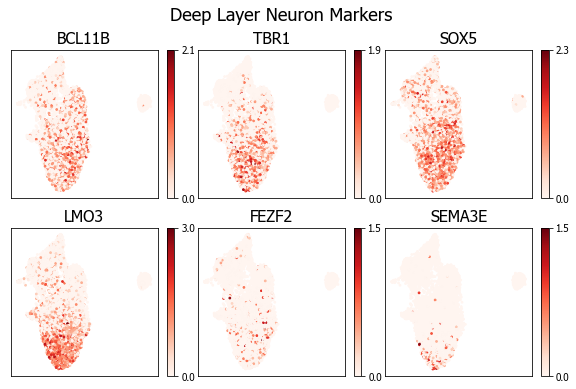

In [10]:
adata.var['index'] = range(len(adata.var))
plt.figure(figsize=(10,6))
for j,gene in enumerate(['BCL11B','TBR1','SOX5','LMO3','FEZF2','SEMA3E']):    

    ax = plt.subplot(2,3,j+1)

    vmin = 0
    vmax = max(adata.X[:,adata.var.loc[gene]['index']])
    colormap = cm.Reds
    normalize = Normalize(vmin=vmin, vmax=vmax)
    xs = adata.obsm['X_umap'][:,0]
    ys = adata.obsm['X_umap'][:,1]
    plt.scatter(xs,ys,c=adata.X[:,list(adata.var.index).index(gene)],
                cmap=colormap,norm=normalize,s=3)

    print(gene)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.title(gene,fontsize=16)
    cbar = plt.colorbar()#colormap)
    cbar.set_ticks([0,vmax],[0,vmax])
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
plt.subplots_adjust(hspace = .2,wspace = .02)
plt.suptitle('Deep Layer Neuron Markers',fontsize=18)
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/Figures/Figure 6/deep_layer_neurons.png',dpi=500,bbox_inches='tight')
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/Figures/Figure 6/deep_layer_neurons.pdf',bbox_inches='tight')

... storing 'tx' as categorical


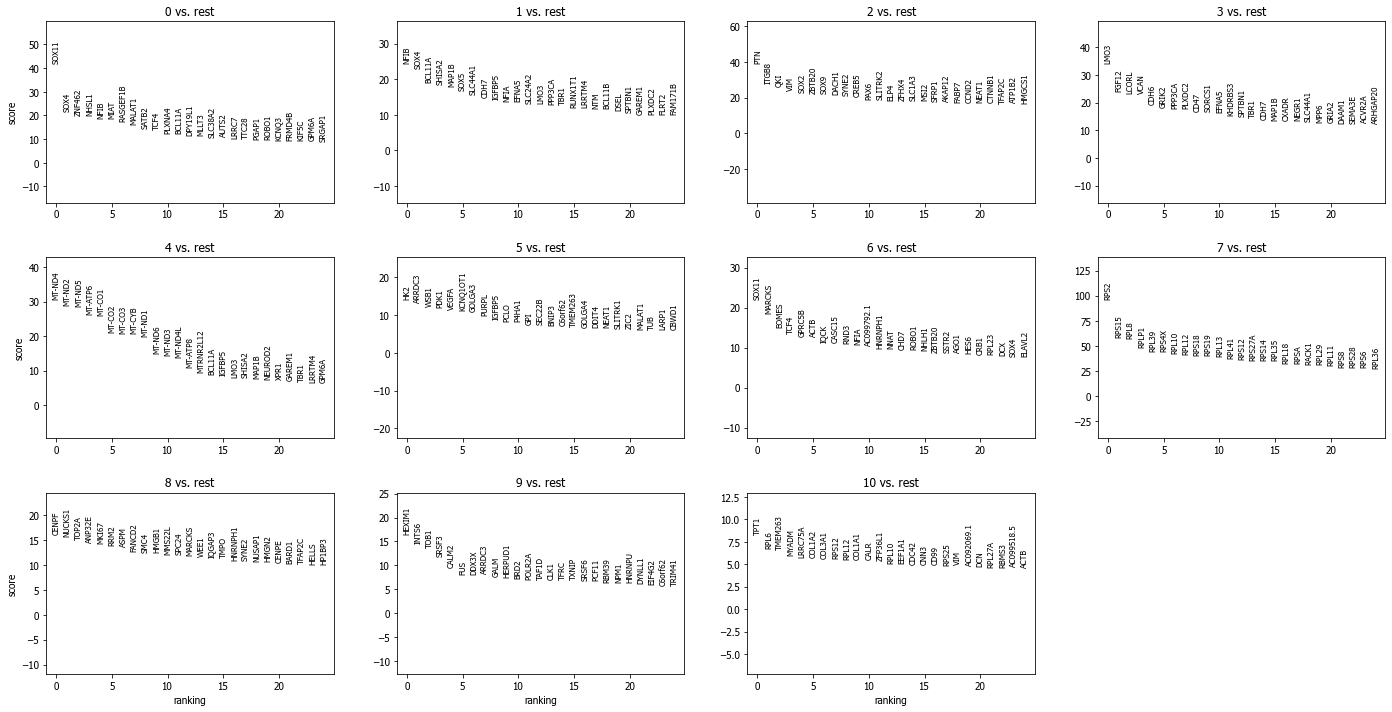

In [11]:
### run marker gene analysis
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test_overestim_var', n_genes=40000)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [12]:
cell_type_dict = {}
for clust in ['10']:
    cell_type_dict[clust] = 'Mesoderm'
for clust in ['7']:
    cell_type_dict[clust] = 'Unknown'
for clust in ['2']:
    cell_type_dict[clust] = 'Cortical NSC'
for clust in ['8']:
    cell_type_dict[clust] = 'Cortical NSC/IP Dividing'
for clust in ['6']:
    cell_type_dict[clust] = 'Cortical IP'
for clust in ['0']:
    cell_type_dict[clust] = 'Upper Layer Neuron'
for clust in ['1','3','4','5']:
    cell_type_dict[clust] = 'Deep Layer Neuron'
for clust in ['9']:
    cell_type_dict[clust] = 'Cortical Neuron'
    
adata.obs['cell_type']=[cell_type_dict[x] for x in adata.obs['louvain']]

cell_type_new = []
for cell_type in adata.obs['cell_type']:
    cell_type_new.append(cell_type)

adata.obs['cell_type']=cell_type_new

In [13]:
clust_dict = {}
for clust,cell_type in zip(adata.obs['louvain'],adata.obs['cell_type']):
    clust_dict[clust]=cell_type

In [14]:
rg_comp = {}
log_fc_cutoff = 1
pval_cutoff = 0.05
cluster = adata.obs['louvain'][0]
genes = adata.uns['rank_genes_groups']['names'][cluster]
genes_idx_dict = {}
for j,gene in enumerate(adata.var.index): 
    genes_idx_dict[gene] = j

adata.obs['Index'] = range(len(adata.obs))
bin_arr = adata.X > 0
output=open('../data/day80_sbnx.cluster_markers.tsv','w')
output.write('gene\tcluster\tcell_type\tlogfoldchange\tpct.1\tpct.2\tpval_adj\tsignficiant\n')
for clust in [str(y) for y in sorted([x for x in set(adata.obs['louvain'])])]:
    rg_comp[clust] = {}
    print(clust)
    genes_ = adata.uns['rank_genes_groups']['names'][clust]
    sum1 = np.sum(bin_arr[np.array(adata.obs[adata.obs['louvain'] == clust]['Index']),:],axis=0)
    sum2 = np.sum(bin_arr[np.array(adata.obs[adata.obs['louvain'] != clust]['Index']),:],axis=0)
    n_cells1 = float(len(adata.obs[adata.obs['louvain'] == clust]))
    n_cells2 = float(len(adata.obs[adata.obs['louvain'] != clust]))
    for j,gene in enumerate(genes_):
        logfc = adata.uns['rank_genes_groups']['logfoldchanges'][clust][j]
        pval_adj = adata.uns['rank_genes_groups']['pvals_adj'][clust][j]
        pct1 = sum1[genes_idx_dict[gene]]/n_cells1
        pct2 = sum2[genes_idx_dict[gene]]/n_cells2
        sig_ = 'FALSE'
        if pval_adj < pval_cutoff and logfc > log_fc_cutoff: sig_= 'TRUE'
        output.write(gene+'\t'+str(clust)+'\t'+clust_dict[clust]+'\t'+str(logfc)+'\t'+
            str(pct1) + '\t' + str(pct2) + '\t' + str(pval_adj)+'\t'+sig_+'\n')
        rg_comp[clust][gene] = {'log_fc':logfc,'pval_adj':pval_adj,'pct.1':pct1,'pct.2':pct2}

output.close()

0
1
10
2
3
4
5
6
7
8
9


In [15]:
cell_types = ['Cortical NSC/IP Dividing','Cortical NSC','Cortical IP Dividing','Cortical IP','Cortical Neuron']
clrs = sns.color_palette('nipy_spectral', n_colors=5)  # a list of RGB tuples

clust_color_dict = {'2':clrs[1],'8':clrs[0],'6':clrs[3],'10':'forestgreen','7':'lightgray',
                   '0':'orangered','1':'salmon','3':'indianred','4':'darkred','5':'mediumvioletred','9':'darkviolet'}

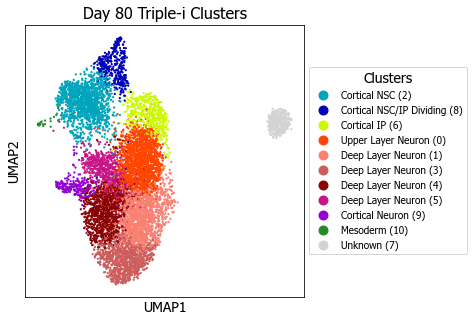

In [16]:
plt.figure(figsize=(10,5))
ax = plt.subplot(111)
clusts = ['2','8','6','0','1','3','4','5','9','10','7']
clrs = sns.color_palette('nipy_spectral', n_colors=len(clusts))  # a list of RGB tuples
final_colors = []
for j,cell in enumerate(adata.obs['louvain']): 
    final_colors.append(clust_color_dict[cell])

plt.scatter(adata.obsm['X_umap'][:,0],adata.obsm['X_umap'][:,1],c=final_colors,s=5,ec=None)
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
for j,cell_type in enumerate(clusts):
    plt.plot(-10000,-10000,'.',color=clust_color_dict[cell_type],label=clust_dict[cell_type]+' ('+cell_type+')',markersize=18)

plt.title('Day 80 Triple-i Clusters', fontsize=16)
plt.xlabel('UMAP1',fontsize=14)
plt.ylabel('UMAP2',fontsize=14)
plt.xticks([])
plt.yticks([])
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.5, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=10,title='Clusters',title_fontsize=14)
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/Figures/Figure 6/umap_clusters.png',dpi=500,bbox_inches='tight')
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/Figures/Figure 6/umap_clusters.pdf',bbox_inches='tight')
plt.show()

In [17]:
clust_order = ['2','8','6','0','1','3','4','5','9','10','7']
genes_to_plot = ['FOXG1','SOX2','LIFR','HOPX','PTPRZ1',
                 'EOMES','DCX','STMN2','NEUROD6',
                 'CUX1','POU3F2','POU3F3','TLE3','EPHA3','BHLHE22','SATB2','CUX2',
                 'SOX5','BCL11B','TBR1',
                 'FEZF2','LMO3','CRYM','NR4A2','SEMA3E','TLE4']

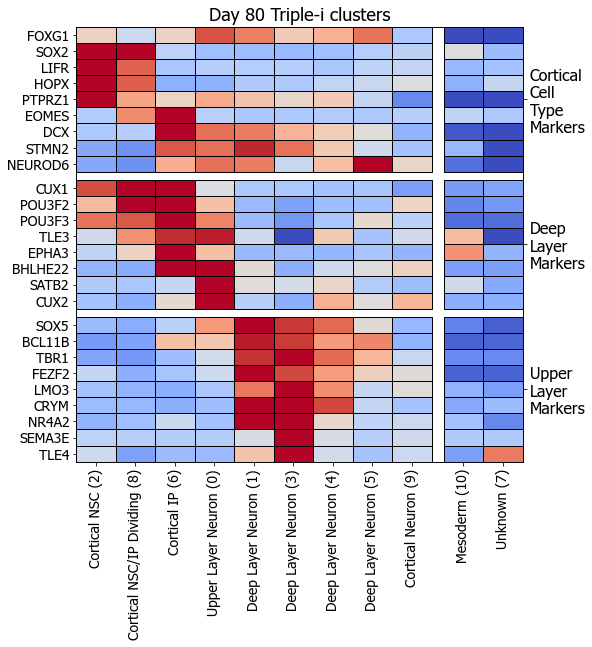

In [18]:
adata.obs['index'] = range(len(adata.obs))

colormap = cm.coolwarm
normed_cmap = Normalize(vmin=-1.5, vmax=1.5)
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)

## calculate zscores per gene per cluster (list ordered by ordered_clusters)
zscores_per_gene = {}
normed_vals_per_gene = {}

for j,gene in enumerate(genes_to_plot):
    if gene in adata.var.index:
        gene_idx = list(adata.var.index).index(gene)
        log_expr_vals_arr = []
        for clust in clust_order:
            log_expr_vals_arr.append(np.mean(adata.X[adata.obs[adata.obs['louvain']==clust]['index'],gene_idx]))
        log_expr_vals_arr = np.array(log_expr_vals_arr)
        mean_vals = np.mean(log_expr_vals_arr)
        std_dev = np.std(log_expr_vals_arr)
        zscores_per_gene[gene] = (log_expr_vals_arr-mean_vals)/std_dev
        normed_vals_per_gene[gene] = (log_expr_vals_arr-min(log_expr_vals_arr))/(max(log_expr_vals_arr)-min(log_expr_vals_arr))
    else:
        zscores_per_gene[gene] = np.array([-2]*len(ordered_clusters))

y_idx = 0
y_ticks = []
for j,gene in enumerate(genes_to_plot):
    if gene in ['CUX1','SOX5']: y_idx += 0.5
    x_ticks = []
    x_idx = 0
    for k,clust in enumerate(clust_order):
        if clust == '10': x_idx += 0.3
        val = zscores_per_gene[gene][k]
        color = tuple(np.array(colormap(normed_cmap(val),bytes=True))/255.)
        p = patches.Rectangle((x_idx-1/2.,-y_idx-1/2.), 1, 1, fill=True, 
                                  facecolor=color, linestyle='-',edgecolor='black')
        ax.add_patch(p)
        x_idx += 1
        x_ticks.append(x_idx-1)
    y_idx += 1
    y_ticks.append(-y_idx+1)

plt.ylim(-y_idx+0.5,0.5)
plt.yticks(y_ticks,genes_to_plot,fontsize=14)
ax.yaxis.set_ticks_position("left")
ax2 = ax.twinx()
plt.yticks([-4,-13,-22],['Cortical\nCell\nType\nMarkers','Deep\nLayer\nMarkers','Upper\nLayer\nMarkers'],fontsize=16)
plt.ylim(-y_idx+0.5,0.5)
ax2.yaxis.set_ticks_position("right")
ax.yaxis.set_ticks_position("left")


plt.xlim(-0.5,x_idx-0.5)
ax.set_xticks(x_ticks)
ax.set_xticklabels([clust_dict[clust]+' ('+clust+')' for clust in clust_order],rotation=90,fontsize=14)
plt.title('Day 80 Triple-i clusters',fontsize=18)
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/Figures/Figure 6/cortical_neuron_layers_heatmap.png',dpi=500,bbox_inches='tight')
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/Figures/Figure 6/cortical_neuron_layers_heatmap.pdf',bbox_inches='tight')

In [19]:
loom_fn = '/mnt/e/MPIMG/Elkabetz/scrna/d80_organoids/data/mpimg_L22589-1_D80-T.loom'
adata_scv = scv.read(loom_fn, cache=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [20]:
adata_scv.var_names_make_unique()

In [21]:
adata_scv.obs.index = [x.split(":")[1][:-1]+'-1' for x in adata_scv.obs.index]
adata_scv = adata_scv[adata.obs.index]
adata_scv.obs = adata.obs.loc[adata_scv.obs.index]

In [22]:
adata_scv.obsm['X_umap'] = adata.obsm['X_umap']
adata_scv.obs['Clusters'] = list(adata.obs['louvain'])
adata_scv.obs['cell_type'] = list(adata.obs['cell_type'])
adata_scv.obs['louvain'] = list(adata.obs['louvain'])
adata_scv.obs['_X'] = list(adata.obsm['X_umap'][:,0])
adata_scv.obs['_Y'] = list(adata.obsm['X_umap'][:,1])

In [23]:
adata_scv = adata_scv[(adata_scv.obs['cell_type']!='Mesoderm') & (adata_scv.obs['cell_type']!='Unknown')]
adata_scv.obs['cell_type'] = adata_scv.obs['cell_type'].astype('category')
adata_scv.obs['louvain'] = adata_scv.obs['louvain'].astype('category')

Trying to set attribute `.obs` of view, copying.


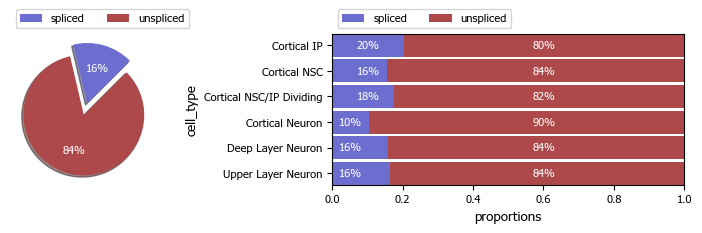

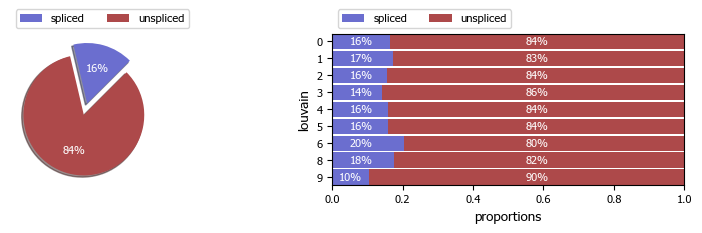

In [24]:
scv.pl.proportions(adata_scv, groupby='cell_type')
scv.pl.proportions(adata_scv, groupby='louvain')

In [25]:
scv.pp.filter_and_normalize(adata_scv, min_shared_counts = 30)

Filtered out 29605 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


In [26]:
len(adata_scv.var)

3933

In [27]:
scv.pp.moments(adata_scv, n_neighbors = 30 )

computing neighbors
    finished (0:00:09) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [28]:
scv.tl.velocity(adata_scv, mode='deterministic', )

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [29]:
scv.tl.velocity_graph(adata_scv, )

computing velocity graph
    finished (0:00:10) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [30]:
adata_scv.obsm['X_umap'] = np.array([np.array(adata_scv.obs._X),np.array(adata_scv.obs._Y)]).transpose()

In [31]:
celltype_clust = []
for cell_type,clust in zip(adata_scv.obs['cell_type'],adata_scv.obs['louvain']):
    celltype_clust.append(cell_type+' ('+clust+')')
adata_scv.obs['cell_type_clust'] = celltype_clust

In [32]:
new_colors = []
for clust in sorted(set(adata_scv.obs['cell_type_clust'])):
    new_colors.append(clust_color_dict[clust.split("(")[1][:-1]])
adata_scv.uns['cell_type_clust_colors'] = new_colors

computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_figures/velocity_stream_plot.png


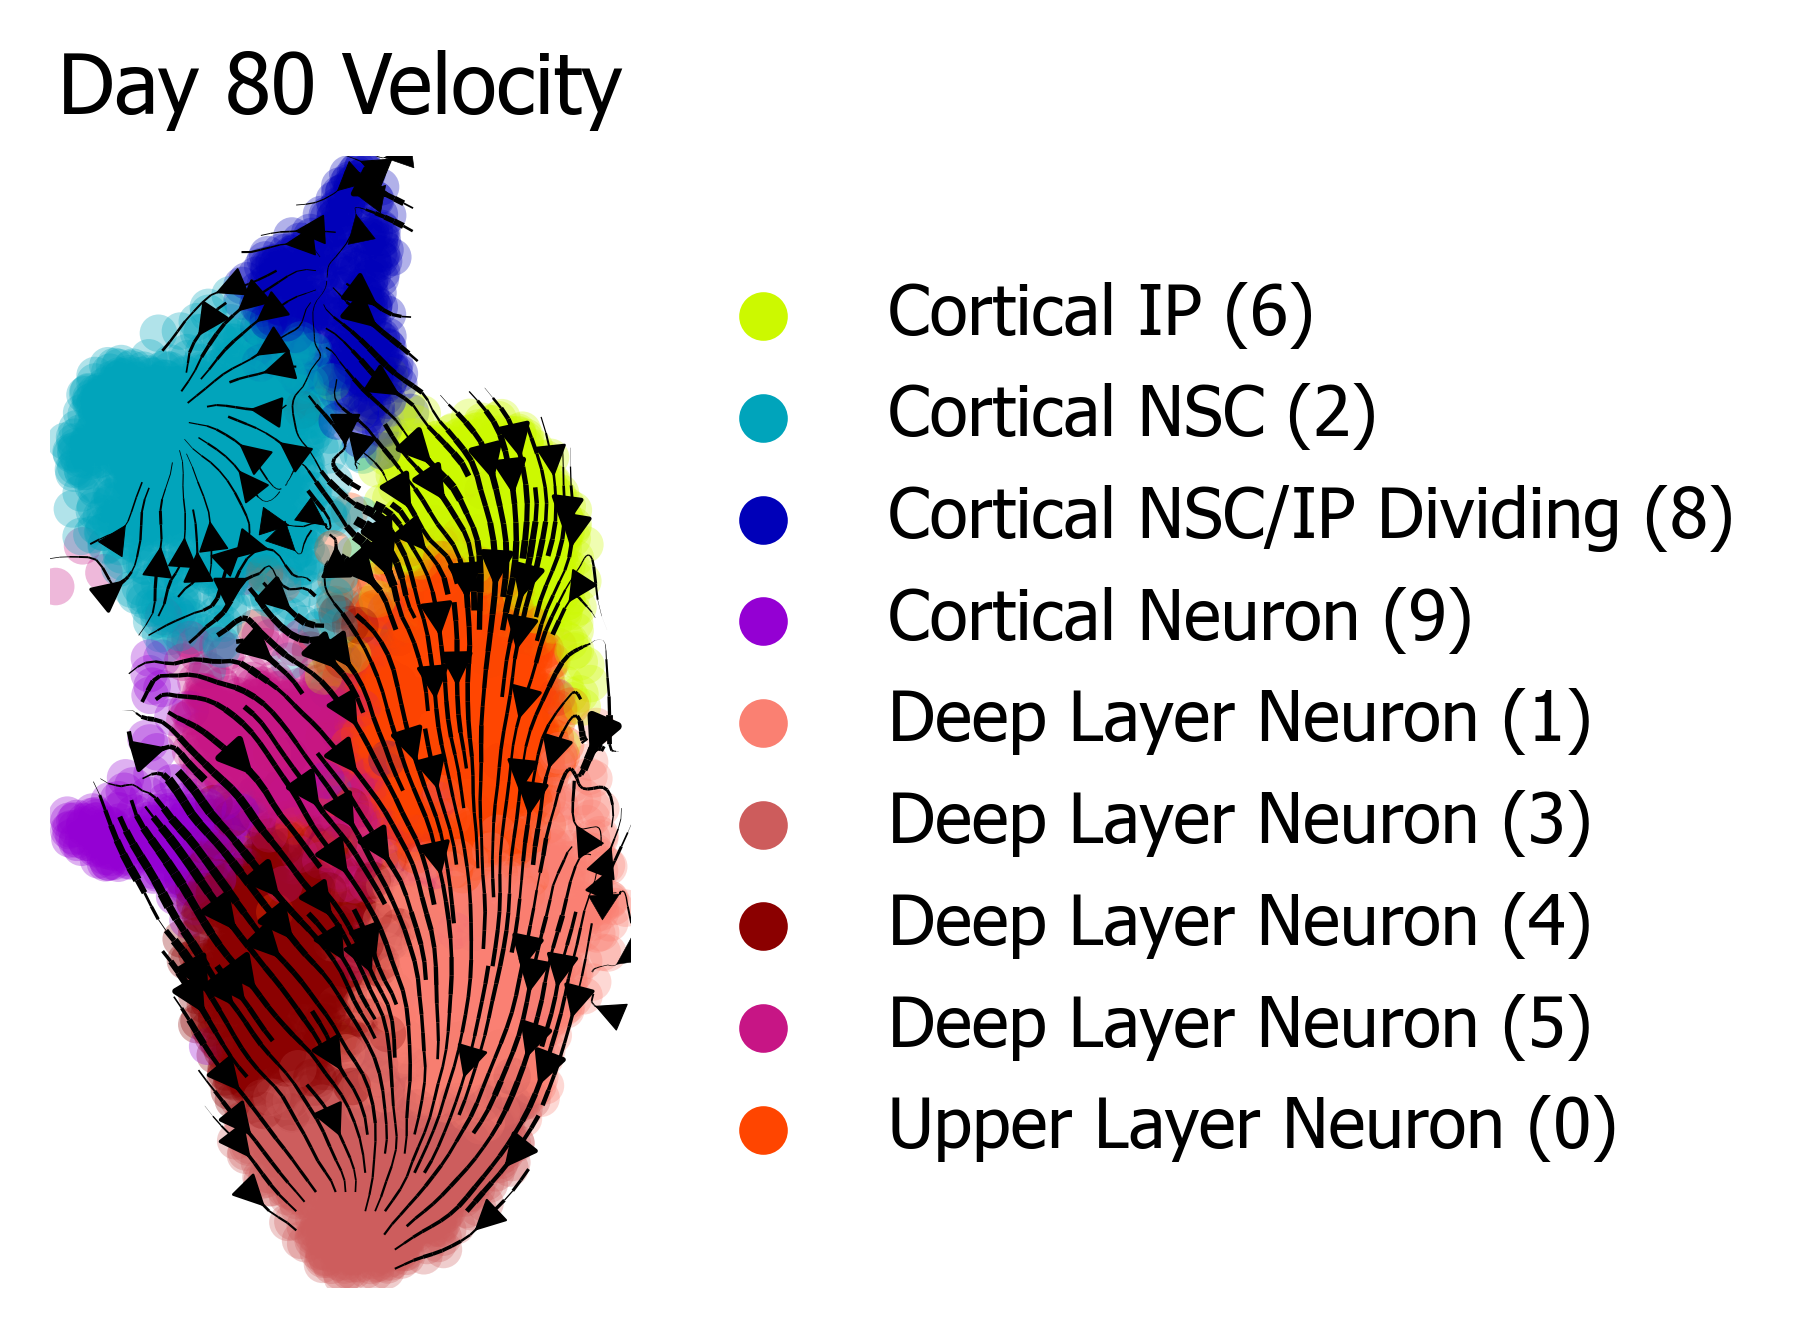

In [33]:
scv.pl.velocity_embedding_stream(adata_scv, basis='umap', color=['cell_type_clust'],figsize=(1.5,3), legend_loc = 'right margin',
                                cmap='nipy_spectral', title = 'Day 80 Velocity',fontsize=12,
                                save='figures/velocity_stream_plot.png',dpi=500, )

In [34]:
def plot_violin_with_fig(adata,gene,clust_order,clust_annot,ax,cnt,full_cnt,xlim,colors=None,xticks=None):
    
    if xticks is None:
        plt.xticks(clust_order)
        
    vals = []
    if gene in adata.obs.columns:
        for clust in clust_order:
            vals.append(adata.obs[adata.obs[clust_annot]==clust][gene])
    else:
        for clust in clust_order:
            vals.append(adata_scv.layers['velocity'][adata.obs[clust_annot]==clust][:,list(adata.var.index).index(gene)])
    parts = ax.violinplot(vals, showmeans=False, showmedians=False,showextrema=False, widths=0.9, bw_method='silverman')
    for j,pc in enumerate(parts['bodies']):
        if colors is None:
            pc.set_facecolor('gray')
        else:
            pc.set_facecolor(colors[j])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    ax.set_xticks([])
    
    for j,val in enumerate(vals):
        plt.plot([j+1]*len(val)+np.random.randn(len(val))*0.1,val,'o',markersize=0.1,color='black')
    
    y0,y1 = plt.ylim()
    plt.ylim(y0,y1+0.1)
    
    plt.xlim(xlim)
    
    if cnt==full_cnt-1:
        ax.set_xticks(range(1,len(clust_order)+1))
        ax.set_xticklabels(xticks,rotation=90,fontsize=12)
    else:
        plt.xticks([])
        
    return fig

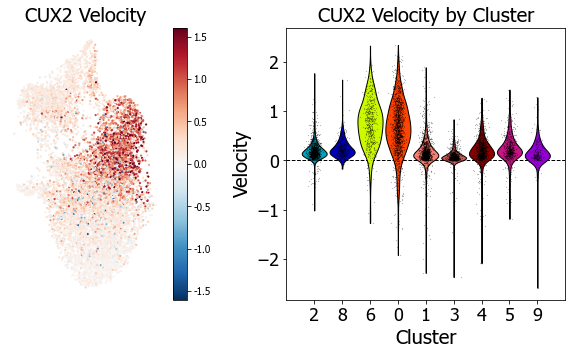

In [35]:
gene = 'CUX2'
clust_order = ['2','8','6','0','1','3','4','5','9']#,'10','7']
clust_annot = 'louvain'

fig = plt.figure(figsize=(10,5))

gs = gridspec.GridSpec(7,20,wspace=0.01, hspace=0.01)
    
ax = plt.subplot(gs[:,0:7])

vmin = min(adata_scv.layers['velocity'][:,list(adata_scv.var.index).index(gene)])
vmax = max(adata_scv.layers['velocity'][:,list(adata_scv.var.index).index(gene)])
vmin = sorted(adata_scv.layers['velocity'][:,list(adata_scv.var.index).index(gene)])[int(0.01*len(adata_scv.obs))]
vmax = sorted(adata_scv.layers['velocity'][:,list(adata_scv.var.index).index(gene)])[int(0.99*len(adata_scv.obs))]
vmin = -vmax
colormap = cm.RdBu_r
normalize = Normalize(vmin=vmin, vmax=vmax)
xs = adata_scv.obsm['X_umap'][:,0]
ys = adata_scv.obsm['X_umap'][:,1]
plt.scatter(xs,ys,c=adata_scv.layers['velocity'][:,list(adata_scv.var.index).index(gene)],cmap=colormap,norm=normalize,s=5,ec=None)
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.title(gene+' Velocity',fontsize=20)
plt.axis('off')
cbar = plt.colorbar()#colormap)\
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax = plt.subplot(gs[:,10:])
cnt=0
cnt_lim=1
colors = [clust_color_dict[clust] for clust in clust_order]
max_prev = 0
fig = plot_violin_with_fig(adata_scv,gene,clust_order,clust_annot,ax,
                           cnt,cnt_lim,xlim=(0,len(clust_order)+1),
                           colors=colors,xticks=clust_order)
plt.title(gene+' Velocity by Cluster',fontsize=20)
plt.xticks(range(1,len(clust_order)+1),clust_order,rotation=0,fontsize=18)
plt.yticks(fontsize=18)
plt.axhline(0,zorder=-1,linestyle='--',color='black',linewidth=1)
plt.ylabel('Velocity',fontsize=20)
plt.xlabel('Cluster',fontsize=20)

plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/Figures/Figure 6/velocyto_plots_indiv_genes.'+gene+'.png',dpi=500,bbox_inches='tight')
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/Figures/Figure 6/velocyto_plots_indiv_genes.'+gene+'.pdf',bbox_inches='tight')

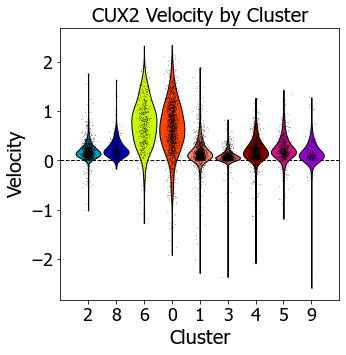

In [36]:
gene = 'CUX2'
clust_order = ['2','8','6','0','1','3','4','5','9']#,'10','7']
clust_annot = 'louvain'

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)

cnt=0
cnt_lim=1
colors = [clust_color_dict[clust] for clust in clust_order]
max_prev = 0
fig = plot_violin_with_fig(adata_scv,gene,clust_order,clust_annot,ax,
                           cnt,cnt_lim,xlim=(0,len(clust_order)+1),
                           colors=colors,xticks=clust_order)
plt.title(gene+' Velocity by Cluster',fontsize=20)
plt.xticks(range(1,len(clust_order)+1),clust_order,rotation=0,fontsize=18)
plt.yticks(fontsize=18)
plt.axhline(0,zorder=-1,linestyle='--',color='black',linewidth=1)
plt.ylabel('Velocity',fontsize=20)
plt.xlabel('Cluster',fontsize=20)

plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/Figures/Figure 6/velocyto_plots_violin.'+gene+'.png',dpi=500,bbox_inches='tight')
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Revision/Figures/Figure 6/velocyto_plots_violin.'+gene+'.pdf',bbox_inches='tight')